In [1]:
import pandas as pd
import numpy as np
import os
from urllib.request import urlretrieve
import partridge as ptg
import peartree as ptr
import plotly.express as px
import networkx as nx

from commons import *

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH, "sources.csv")).set_index("mdb_source_id")
df

,data_type,entity_type,location.country_code,location.subdivision_name,location.municipality,provider,name,note,feed_contact_email,static_reference,...,urls.license,location.bounding_box.minimum_latitude,location.bounding_box.maximum_latitude,location.bounding_box.minimum_longitude,location.bounding_box.maximum_longitude,location.bounding_box.extracted_on,status,features,redirect.id,redirect.comment
mdb_source_id,,,,,,,,,,,,,,,,,,,,,
1,gtfs,NaN,US,Maine,Casco Bay,Casco Bay Lines,NaN,NaN,NaN,NaN,...,NaN,43.655373,43.716190,-70.248666,-70.110180,2022-02-22T19:51:22+00:00,inactive,NaN,NaN,NaN
2,gtfs,NaN,CA,Ontario,London,London Transit Commission,NaN,NaN,croy@londontransit.ca,NaN,...,https://www.londontransit.ca/open-data/ltcs-op...,42.905244,43.051188,-81.363110,-81.137591,2022-02-22T19:51:34+00:00,NaN,NaN,NaN,NaN
3,gtfs,NaN,CA,Ontario,Barrie,Barrie Transit,NaN,NaN,NaN,NaN,...,https://www.barrie.ca/services-payments/transp...,44.321804,44.420207,-79.740632,-79.610896,2022-03-01T22:43:25+00:00,NaN,NaN,NaN,NaN
4,gtfs,NaN,US,Ohio,Athens,Athens Public Transit,NaN,NaN,NaN,NaN,...,NaN,39.295665,39.399200,-82.141964,-82.027972,2022-03-23T14:43:11+00:00,deprecated,NaN,1973.0,NaN
5,gtfs,NaN,US,New York,Canton,St Lawrence County Public Transit,NaN,NaN,NaN,NaN,...,https://data.ny.gov/download/77gx-ii52/applica...,44.148476,44.979369,-75.756950,-74.611761,2022-03-14T20:02:31+00:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,gtfs,NaN,US,Ohio,Athens,Athens Public Transit,NaN,NaN,info@athenspublictransit.org,NaN,...,NaN,39.223943,39.469958,-82.250627,-82.028000,2024-01-18T22:25:23+00:00,NaN,NaN,NaN,NaN
1974,gtfs,NaN,US,California,Concord,Tri Delta Transit,NaN,NaN,511sfbaydeveloperresources@googlegroups.com,NaN,...,https://511.org/sites/default/files/pdfs/511_D...,37.895701,38.039856,-122.139478,-121.691400,2024-01-22T18:17:58+00:00,active,NaN,NaN,NaN
1975,gtfs-rt,tu,US,California,Concord,Tri Delta Transit,NaN,NaN,NaN,1974.0,...,https://511.org/sites/default/files/pdfs/511_D...,37.895701,38.039856,-122.139478,-121.691400,2024-01-22T18:17:58+00:00,NaN,NaN,NaN,NaN


In [3]:
src = GTFS_PATH_OTHER
example_feed = 1139
in_path = os.path.join(src, f'{example_feed}.zip')

In [4]:
graph_name = str(df.loc[example_feed]["location.municipality"]).replace(" ", "-")
max_lats, max_longs, min_lats, min_longs = df.loc[example_feed][["location.bounding_box.maximum_latitude",
                                                            "location.bounding_box.maximum_longitude",
                                                            "location.bounding_box.minimum_latitude",
                                                            "location.bounding_box.minimum_longitude"]]
service_ids = min(ptg.read_service_ids_by_date(in_path).items())[1]
geo_shapes = ptg.load_geo_feed(in_path).shapes
feed = ptg.load_feed(in_path)

lats, longs, names = [], [], []
for row in list(geo_shapes.iterrows()):
    name, linestring = row[1]
    x, y = linestring.xy
    lats = np.append(lats, y)
    longs = np.append(longs, x)
    names = np.append(names, [name] * len(y))
    lats = np.append(lats, None)
    longs = np.append(longs, None)
    names = np.append(names, None)

F:\anaconda\envs\DA_TrNet\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
# find middle of the bounding box
middle_lat = (max_lats + min_lats) / 2
middle_long = (max_longs + min_longs) / 2
middle_long, middle_lat

(19.7149935, 49.025284)

In [ ]:
fig = px.line_mapbox(lat=lats, lon=longs, hover_name=names)
fig.update_layout(mapbox_style="open-street-map", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [14]:
start = 7*60*60
end = 22*60*60

date_min, service_ids_min = min(ptg.read_service_ids_by_date(in_path).items())
date_max, service_ids_max = max(ptg.read_service_ids_by_date(in_path).items())
view_min, view_max = {'trips.txt': {'service_id': service_ids_min}}, {'trips.txt': {'service_id': service_ids_max}}
feed_min = ptg.load_feed(in_path, view=view_min)
feed_max = ptg.load_feed(in_path, view=view_max)
g_min = ptr.load_feed_as_graph(feed_min, start, end, name="Trenitalia")
g_max = ptr.load_feed_as_graph(feed_max, start, end, name="Trenitalia")

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

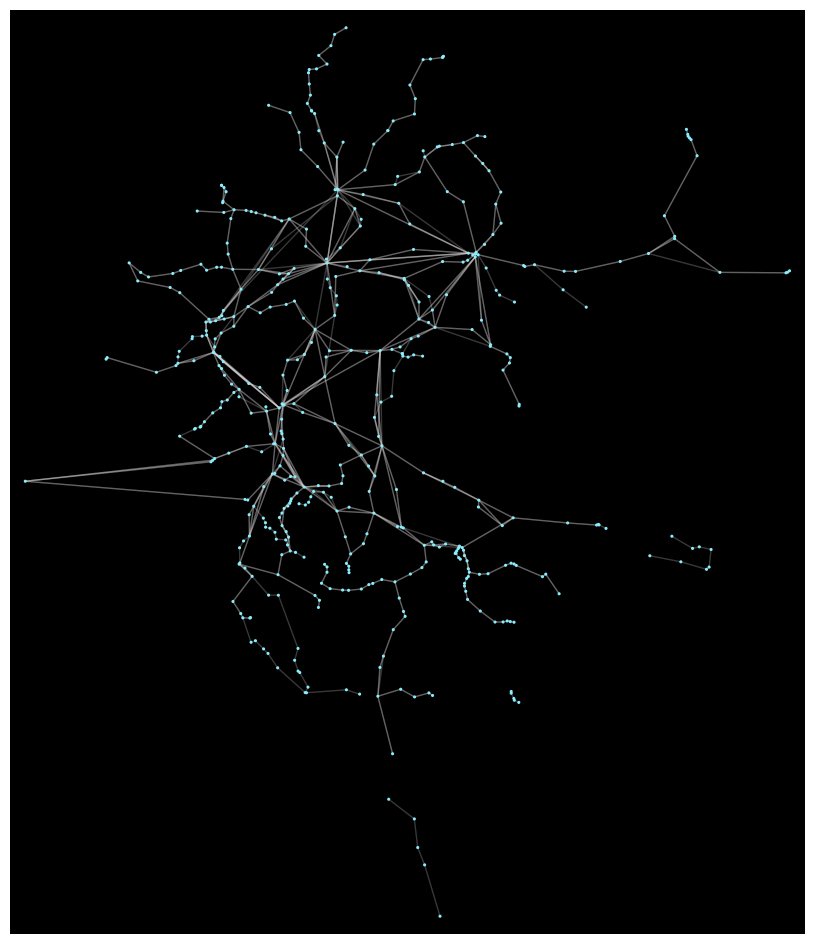

In [15]:
ptr.generate_plot(g_min)

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

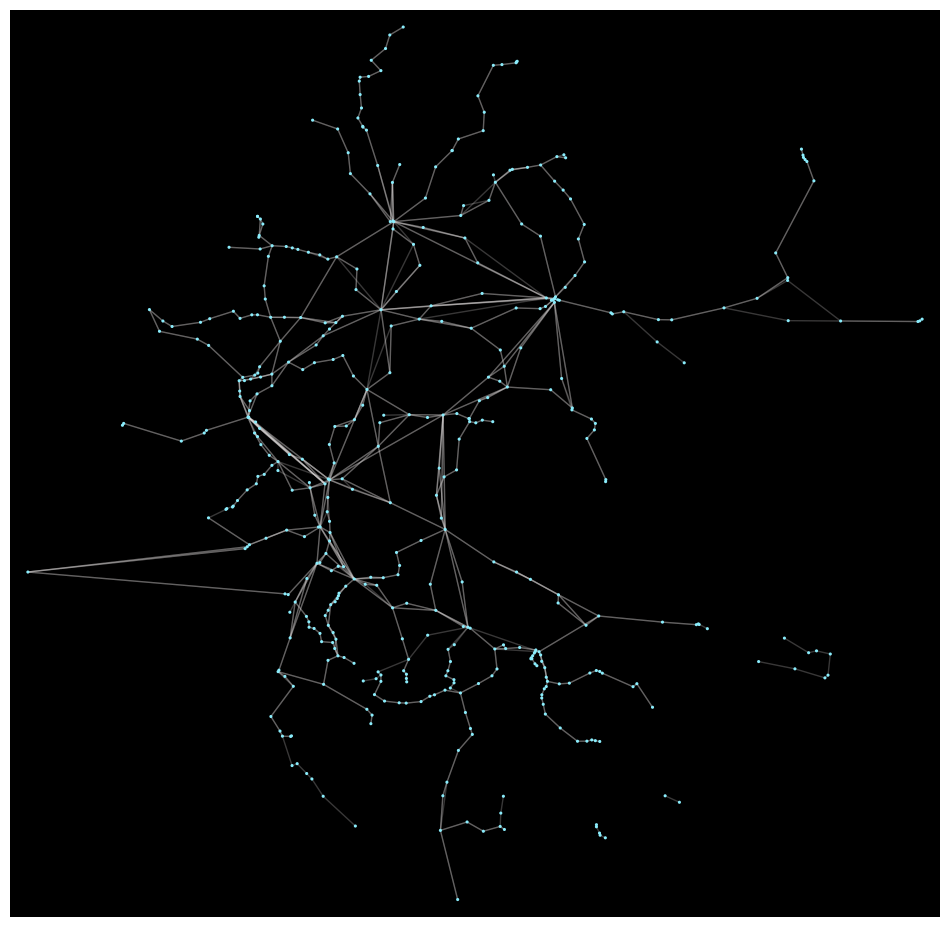

In [16]:
ptr.generate_plot(g_max)

In [17]:
nx.utils.graphs_equal(g_min, g_max)

False

In [18]:
date_min, date_max

(datetime.date(2018, 12, 9), datetime.date(2019, 12, 14))

In [19]:
(g_min.number_of_nodes(), g_max.number_of_nodes()), (g_min.number_of_edges(), g_max.number_of_edges())

((488, 456), (1204, 1138))